In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Spring2023/cs231n/projects'
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Spring2023/cs231n/projects')

In [3]:
import json
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import Dataset

class SkiDataset(Dataset):
    '''2D alpine skiing dataset'''

    # BGR channel-wise mean and std
    all_mean = torch.Tensor([190.24553031, 176.98437134, 170.87045832]) / 255
    all_std  = torch.Tensor([ 36.57356531,  35.29007466,  36.28703238]) / 255
    train_mean = torch.Tensor([190.37117484, 176.86400202, 170.65409075]) / 255
    train_std  = torch.Tensor([ 36.56829177,  35.27981661,  36.19375109]) / 255

    # Corresponding joints
    joints = ['head', 'neck',
              'shoulder_right', 'elbow_right', 'hand_right', 'pole_basket_right',
              'shoulder_left', 'elbow_left', 'hand_left', 'pole_basket_left',
              'hip_right', 'knee_right', 'ankle_right',
              'hip_left', 'knee_left', 'ankle_left',
              'ski_tip_right', 'toes_right', 'heel_right', 'ski_tail_right',
              'ski_tip_left', 'toes_left', 'heel_left', 'ski_tail_left']

    # Bones for drawing examples
    bones = [[0,1], [1,2], [2,3], [3,4], [4,5], [1,6], [6,7], [7,8], [8,9],
             [2,10], [10,11], [11,12], [6,13], [13,14], [14,15],
             [16,17], [17,18], [18,19], [12,17], [12,18],
             [20,21], [21,22], [22,23], [15,21], [15,22]]

    # VideoIDs and SplitIDs used for validation
    val_splits = [('5UHRvqx1iuQ', '0'), ('5UHRvqx1iuQ', '1'),
                  ('oKQFABiOTw8', '0'), ('oKQFABiOTw8', '1'), ('oKQFABiOTw8', '2'),
                  ('qxfgw1Kd98A', '0'), ('qxfgw1Kd98A', '1'),
                  ('uLW74013Wp0', '0'), ('uLW74013Wp0', '1'),
                  ('zW1bF2PsB0M', '0'), ('zW1bF2PsB0M', '1')]


    def __init__(self, imgs_dir, label_path, img_extension='png', mode='all', img_size=(1920,1080),
                 normalize=True, in_pixels=True, return_info=False, transform=None):
        '''
        Create a Ski2DPose dataset loading train or validation images.

        Args:
            :imgs_dir: Root directory where images are saved
            :label_path: Path to label JSON file
            :img_extension: Image format extension depending on downloaded version. One of {'png', 'jpg', 'webp'}
            :mode: Specify which partition to load. One of {'train', 'val', 'all'}
            :img_size: Size of images to return
            :normalize: Set to True to normalize images
            :in_pixels: Set to True to scale annotations to pixels
            :return_info: Set to True to include image names when getting items
        '''
        self.imgs_dir = imgs_dir
        self.img_extension = img_extension
        self.mode = mode
        self.img_size = img_size
        self.normalize = normalize
        self.in_pixels = in_pixels
        self.return_info = return_info
        self.transform = transform # Added

        assert mode in ['train', 'val', 'all'], 'Please select a valid mode.'
        self.mean = self.all_mean if self.mode == 'all' else self.train_mean
        self.std = self.all_std if self.mode == 'all' else self.train_std

        # Load annotations
        with open(label_path) as f:
            self.labels = json.load(f)

        # Check if all images exist and index them
        self.index_list = []
        for video_id, all_splits in self.labels.items():
            for split_id, split in all_splits.items():
                for img_id, img_labels in split.items():
                    img_path = os.path.join(imgs_dir, video_id, split_id, '{}.{}'.format(img_id, img_extension))
                    if os.path.exists(img_path):
                        if ((mode == 'all') or
                            (mode == 'train' and (video_id, split_id) not in self.val_splits) or
                            (mode == 'val' and (video_id, split_id) in self.val_splits)):
                            self.index_list.append((video_id, split_id, img_id))
                    else:
                        print('Did not find image {}/{}/{}.{}'.format(video_id, split_id, img_id, img_extension))

    def __len__(self):
        '''Returns the number of samples in the dataset'''
        return len(self.index_list)

    def __getitem__(self, index):
        '''
        Returns image tensor (H x W x C) in BGR format with values between 0 and 255,
        annotation tensor (J x 2) and visibility flag tensor (J).

        If 'normalize' flag was set to True, returned image will be normalized
        according to mean and std above.

        If 'return_info' flag was set to True, returns (video_id, split_id, img_id, frame_idx)
        in addition.

        Args:
            :index: Index of data sample to load
        '''
        # Load annotations
        video_id, split_id, img_id = self.index_list[index]
        annotation = self.labels[video_id][split_id][img_id]['annotation']
        frame_idx  = self.labels[video_id][split_id][img_id]['frame_idx']
        an = torch.Tensor(annotation)[:,:2]
        vis = torch.LongTensor(annotation)[:,2]

        # Load image
        img_path = os.path.join(self.imgs_dir, video_id, split_id, '{}.{}'.format(img_id, self.img_extension))
        img = cv2.imread(img_path) # (H x W x C) BGR
        if self.img_size is not None:
            img = cv2.resize(img, self.img_size)
        img = torch.from_numpy(img)


        if self.normalize:
            img = ((img / 255) - self.mean) / self.std
        if self.in_pixels:
            an *= torch.Tensor([img.shape[1], img.shape[0]])
        if self.return_info:
            return img, an, vis, (video_id, split_id, img_id, frame_idx)
        
        # Added: reorder dimensions
        img = img.permute(2, 0, 1)

        # Added
        if self.transform:
            img = self.transform(img)  # Apply the transform to the image

        return img, an, vis

    def annotate_img(self, img, an, vis, info=None):
        '''
        Annotates a given image with all joints. Visible joints will be drawn
        with a red circle, while invisible ones with a blue one.

        Args:
            :img: Input image (in pixels)
            :an: Annotation positions tensor (in pixels)
            :vis: Visibility flag tensor
            :info: (video_id, split_id, img_id, frame_idx) tuple
        '''
        width, height = img.shape[1], img.shape[0]
        img = img.numpy()
        # Scale based on head-foot distance
        scale = torch.norm(an[0] - an[15]) / height
        img_an = img.copy()
        # Draw all bones
        for bone_from, bone_to in self.bones:
            x_from, y_from = an[bone_from]
            x_to, y_to = an[bone_to]
            # MODIFIED: Cast x_from and y_from to int to avoid cv2 error
            cv2.line(img_an, (int(x_from), int(y_from)), (int(x_to), int(y_to)), (0,255,0), int(max(2,5*scale)))
        # Draw all joints
        for (x,y), flag in zip(an, vis):
            color = (0,0,255) if flag == 1 else (255,0,0)
            # MODIFIED: Cast x and y to int to avoid cv2 error
            cv2.circle(img_an, (int(x),int(y)), int(max(2,14*scale)), color, -1)
        # Draw image name and frame number if given
        if info is not None:
            text = 'Image {}, frame {}.'.format(info[2], info[3])
            cv2.putText(img_an, text, (5,40), cv2.FONT_HERSHEY_SIMPLEX, 1.5*(width/1920),
                        (0,0,0), 5, cv2.LINE_AA)
            cv2.putText(img_an, text, (5,40), cv2.FONT_HERSHEY_SIMPLEX, 1.5*(width/1920),
                        (255,255,255), 2, cv2.LINE_AA)
        return img_an


def determine_image_format():
    """
    @return (image_format_name, image_directory)
    """
    formats = ['png', 'webp', 'jpg']

    for img_format in formats:
        img_dir = Path(f'data/Images_{img_format}')
        if img_dir.is_dir():
            print(f'Found image directory {img_dir}, using {img_format} format.')
            return img_format, img_dir

    raise FileNotFoundError('Image directory not found, please ensure one of the following directories exists: ' + \
                            ', '.join(f'Images_{ext}' for ext in formats))

In [5]:
def plot_keypoints(img, annot):
    '''
    Args:
        img: numpy array representing the image
        annot: list of coordinates (tuples) representing the
            keypoints location
    '''
    height = img.shape[0]
    width = img.shape[1]
    fig, ax = plt.subplots()
    im = ax.imshow(img)
    for x, y, visible in annot:
        if visible:
            ax.plot(x*width, y*height, marker="o", markersize = 5, color = 'yellow')
        else:
            ax.plot(x*width, y*height, marker="o", markersize = 5, color = 'pink')
    plt.show()

In [6]:
import torchvision
def get_model():
    # initialize the model
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(num_keypoints=24)
    return model

In [7]:
lr = 0.001
batch_size = 32
epochs = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [9]:
video_ids = os.listdir('data/Images_jpg')
# form: video_id: split_id: image_id:annotation

In [10]:
f = open('data/ski2dpose_labels.json')
labels = json.load(f)

In [11]:
joints = [
  'head', 'neck',
  'shoulder_right', 'elbow_right', 'hand_right', 'pole_basket_right',
  'shoulder_left', 'elbow_left', 'hand_left', 'pole_basket_left',
  'hip_right', 'knee_right', 'ankle_right',
  'hip_left', 'knee_left', 'ankle_left',
  'ski_tip_right', 'toes_right', 'heel_right', 'ski_tail_right',
  'ski_tip_left', 'toes_left', 'heel_left', 'ski_tail_left'
]

In [12]:
os.listdir('data/Images_jpg/v7PADD2_I00/0/')

['v7PADD2_I00_0_00001.jpg',
 'v7PADD2_I00_0_00004.jpg',
 'v7PADD2_I00_0_00002.jpg',
 'v7PADD2_I00_0_00000.jpg',
 'v7PADD2_I00_0_00003.jpg']

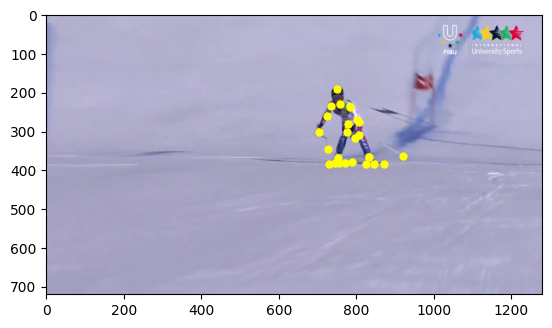

In [13]:
img = plt.imread('data/Images_jpg/v7PADD2_I00/1/v7PADD2_I00_1_00003.jpg')
height = img.shape[0]
width = img.shape[1]
fig, ax = plt.subplots()
im = ax.imshow(img)
for x, y, visible in labels['v7PADD2_I00']['1']['v7PADD2_I00_1_00003']['annotation']:
  if visible:
    ax.plot(x*width, y*height, marker="o", markersize = 5, color = 'yellow')
  else:
    ax.plot(x*width, y*height, marker="o", markersize = 5, color = 'cyan')
plt.show()

In [14]:
label_path = 'data/ski2dpose_labels.json'
img_extension, imgs_dir = determine_image_format()

Found image directory data/Images_jpg, using jpg format.


In [15]:
train_dataset = SkiDataset(imgs_dir=imgs_dir, label_path=label_path, img_extension=img_extension,
                        img_size=(1920,1080), mode='train', normalize=False, in_pixels=True, return_info=False,
                        transform=transform)
val_dataset = SkiDataset(imgs_dir=imgs_dir, label_path=label_path, img_extension=img_extension,
                        img_size=(1920,1080), mode='val', normalize=False, in_pixels=True, return_info=False,
                        transform = transform)

In [16]:
print('Number of images: {}'.format(len(train_dataset)))
print('Number of images: {}'.format(len(val_dataset)))

Number of images: 1830
Number of images: 152


In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)

In [18]:
keypoint_model = get_model().to(DEVICE).eval()
criterion = nn.MSELoss()
optimizer = optim.Adam(keypoint_model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


In [25]:
for epoch in range(epochs):
  keypoint_model.train()
  for i, (images, labels, _) in enumerate(train_dataloader): 
    optimizer.zero_grad()
    
    images = list(image.to(DEVICE) for image in images)
    labels = list(label.to(DEVICE) for label in labels)
    # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    # The model expects targets to be a list of dictionary
    # https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/

    '''
    During training, the model expects both the input tensors and targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the class label for each ground-truth box

    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction

    '''
    loss_dict = keypoint_model(images, labels)
    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    losses.backward

    #losses = criterion(outputs, labels)
    #loss.backward()
    
    optimizer.step()

    '''
    keypoint_model.eval()
    
    with torch.no_grad():
        valid_loss = 0
        for images, labels, _ in test_dataloader:
            outputs = keypoint_model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
        
        valid_loss = valid_loss / len(test_dataloader)
        print(f"Epoch: {epoch + 1}, Validation Loss: {valid_loss:.4f}")
        '''

IndexError: ignored